# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы, и контролировать добросовестность кассиров при продаже алкоголя.
Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. 

В нашем распоряжении данные с сайта [ChaLearn Looking at People](https://chalearnlap.cvc.uab.cat/dataset/26/description/), которые находятся в папке /datasets/faces/, содеражащие набор фотографий людей (папка - /final_files) с указанием возраста (CSV-файл labels.csv).

CSV-файл labels.csv содержит две колонки: 
- `file_name`,
- `real_age`.

<b>Примечание:</b>
- Для оценки качества моделей необходимо применять метрику MSA.
- Значение метрики должно быть не больше 8.

## Исследовательский анализ данных

Импорт необходимых библиотек:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

### Загрузка данных и вывод основной информации

Чтение csv-файла и сохранение в переменную labels:

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

Загрузка изображений:

In [4]:
datagen = ImageDataGenerator(rescale=1./255)
train_datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345)

Found 7591 validated image filenames.


In [5]:
# Функция, выводящая основную информацию о датафрейме
def about_df(data, size=5):
    print(f'Вывод первых {size} строк датафрейма:')
    pd.set_option('display.max_columns', 30)
    display(data.head(size))
    print('\nВывод основной информации о датафрейме:')
    data.info()
    print('\nКоличество пропусков в датафрейме:')
    print(pd.DataFrame(np.array([data.isna().sum(), data.isna().mean()*100]).T, 
                                columns=['количество пропусков', 'доля пропусков, %'], index=data.columns))
    print(f'\nСуммарное количество пропусков в датафрейме: {data.isna().sum().sum()}, '
          + f'доля пропусков: {data.isna().mean().sum()*100} %')
    display(data.describe())

In [6]:
about_df(labels)

Вывод первых 5 строк датафрейма:


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17



Вывод основной информации о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB

Количество пропусков в датафрейме:
           количество пропусков  доля пропусков, %
file_name                   0.0                0.0
real_age                    0.0                0.0

Суммарное количество пропусков в датафрейме: 0, доля пропусков: 0.0 %


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


### Построение гистограммы распределения возраста

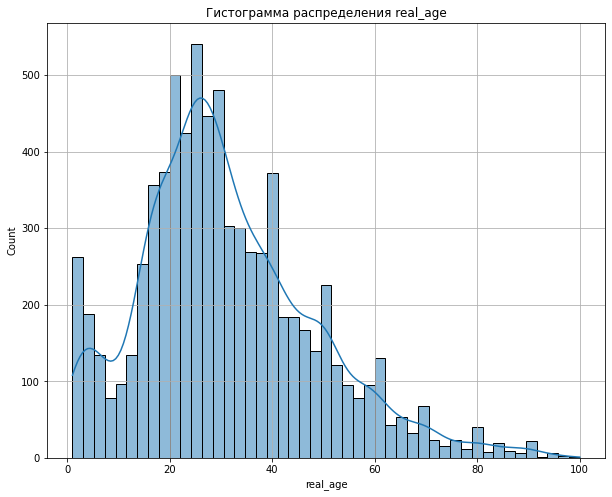

In [7]:
plt.figure(figsize=(10,8))
plt.grid()
w = sns.histplot(data=labels['real_age'], kde=True)
w.set(title=f'Гистограмма распределения real_age')
plt.show()

### Вывод изображений

In [8]:
features, target = next(train_datagen_flow)
print(features.shape)

(32, 224, 224, 3)


Признаки представляют собой четырёхмерный тензор, в котором 32 изображений размером 224x224 с тремя цветовыми каналами.

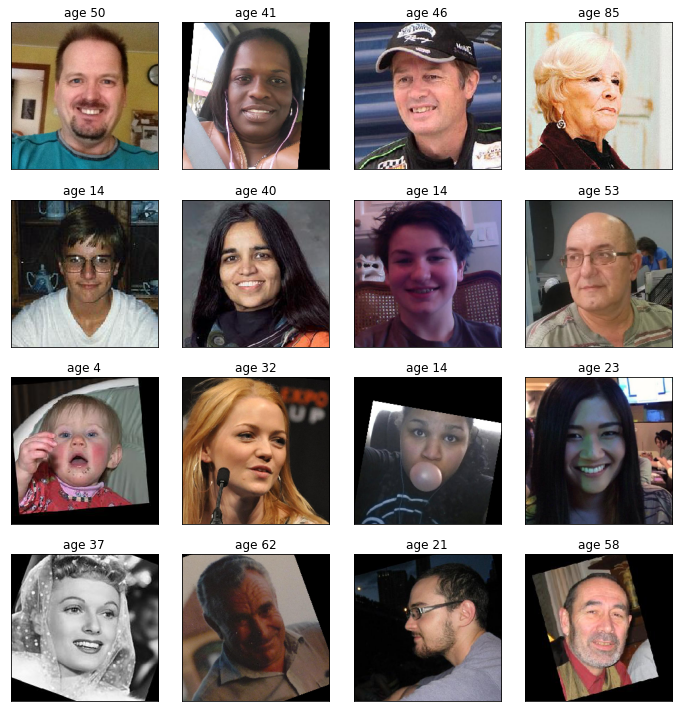

In [11]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.title(f'age {target[i]}')
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

<b>Вывод:</b> Из выведенных характеристик и построенной гистограммы видно, что:
- выборка содержит 7591 изображений людей;
- минимальный возраст человека составляет 1 год;
- максимальный возраст человека составляет 100 лет;
- на гистограмме наблюдается 2 пика (распределение бимодально) соответсвующие возрасту: 1-3 года и 20-30 лет, что может свидетельствовать о разных источникаха данных;
- на гистограмме также наблюдаются отдельные пики, что возможно, является результатом округления возраста;
- возраст большинства людей находится в диапазоне от 15 лет до 41 года;
- не все изображения верно размечены (на 9 фото возраст ребенка не верен);
- все изображения выровнены;
- есть как цветные изображения, так и чб.

В обучающей выборке мало изображений людей в возрасте старше 40 лет, среди которых, как правило, много покупателей. Поэтому модель может чаще ошибаться при определении возраста покупателей из этой возрастной категории.

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

<b>Код:</b>

```
import pandas as pd

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255
    )

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255
    )
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.000025)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


def train_model(model, train_datagen_flow , test_datagen_flow, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_datagen_flow,
              validation_data=test_datagen_flow,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model 
```

<b>Результат:</b>

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-10-15 09:58:57.979138: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-10-15 09:58:59.190804: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 72s - loss: 461.2687 - mae: 16.2350 - val_loss: 1069.6416 - val_mae: 28.1106
Epoch 2/10
178/178 - 38s - loss: 79.3821 - mae: 6.6472 - val_loss: 1041.7489 - val_mae: 27.6557
Epoch 3/10
178/178 - 38s - loss: 34.2683 - mae: 4.4772 - val_loss: 557.8852 - val_mae: 18.4832
Epoch 4/10
178/178 - 38s - loss: 20.8320 - mae: 3.5356 - val_loss: 147.5889 - val_mae: 9.4100
Epoch 5/10
178/178 - 38s - loss: 14.9922 - mae: 2.9672 - val_loss: 100.9696 - val_mae: 7.8281
Epoch 6/10
178/178 - 38s - loss: 12.9247 - mae: 2.7518 - val_loss: 80.1336 - val_mae: 6.8468
Epoch 7/10
178/178 - 38s - loss: 12.2188 - mae: 2.7096 - val_loss: 86.9539 - val_mae: 7.0179
Epoch 8/10
178/178 - 38s - loss: 11.8579 - mae: 2.6572 - val_loss: 76.1005 - val_mae: 6.6001
Epoch 9/10
178/178 - 38s - loss: 11.1526 - mae: 2.5677 - val_loss: 76.7880 - val_mae: 6.6257
Epoch 10/10
178/178 - 38s - loss: 10.4586 - mae: 2.4888 - val_loss: 73.7926 - val_mae: 6.4884
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 73.7926 - mae: 6.4884
Test MAE: 6.4884
```

## Анализ обученной модели

Для определения возраста покупателей была построена свёрточная нейронная сеть на основе архитектуры ResNet50.

В модели были использованы, следующие параметры:
- функция потерь - MSE,
- количество эпох - 10, 
- алгоритм обучения — Adam, 
- шаг с которого стартует алгоритм - 0.000025. 

В результате исследования было получено mae:
- для обучающей выборки, равное <b>2.4888</b>, 
- для валидационной, выборки равное <b>6.4884</b>.

Для улучшения результата рекомендуется:
- дополнить обучающую выборку изображениями людей в возрасте старше 40 лет,
- применить аугментацию изображений.